In [1]:
%pip install -q timm
%pip install -q transformers
%pip install -q kaggle
%pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:0

In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
from PIL import Image
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import json
import gradio as gr

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-2-a33ced7d492d>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anilbhatt1","key":"65b827133aab5137dc9378d8076d2bc4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 '/root/.kaggle/kaggle.json'
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.15G/8.16G [01:01<00:00, 90.8MB/s]
100% 8.16G/8.16G [01:01<00:00, 143MB/s] 


In [ ]:
!unzip -q '/content/flickr-image-dataset.zip'

In [ ]:
image_path = "/content/flickr30k_images/flickr30k_images"
captions_path = ""

### CLIP model training for minimal epochs to get model weights & save them to gdrive

In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 64
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

In [ ]:
CFG.device

device(type='cpu')

In [ ]:
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # # Calculating the Loss
        # logits = (text_embeddings @ image_embeddings.T) / self.temperature
        # images_similarity = image_embeddings @ image_embeddings.T
        # texts_similarity = text_embeddings @ text_embeddings.T
        # targets = F.softmax(
        #     (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        # )
        # texts_loss = cross_entropy(logits, targets, reduction='none')
        # images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        # loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        # return loss.mean()

        # Calculating the Loss
        images_similarity = image_embeddings @ text_embeddings.T / self.temperature
        texts_similarity = images_similarity.T
        labels = torch.arange(batch["image"].shape[0]).long().to(CFG.device)

        total_loss = (
            F.cross_entropy(images_similarity, labels) +
            F.cross_entropy(texts_similarity, labels)
        ) / 2

        return total_loss


# def cross_entropy(preds, targets, reduction='none'):
#     log_softmax = nn.LogSoftmax(dim=-1)
#     loss = (-targets * log_softmax(preds)).sum(1)
#     if reduction == "none":
#         return loss
#     elif reduction == "mean":
#         return loss.mean()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_image_embeddings.npy" '/content'

In [ ]:
  !cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_text_embeddings.npy" '/content'

In [ ]:
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/best_clip_model_cpu.pt" '/content'

In [ ]:
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/val_img_file_names.npy" '/content'

### Inferencing with items we saved in gdrive in cpu mode

In [ ]:
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
def find_matches_cpu(model, image_embeddings, query, image_filenames, n=4):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to('cpu')
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

In [ ]:
model_inf = CLIPModel().to('cpu')
model_inf.load_state_dict(torch.load('/content/best_clip_model_cpu.pt', map_location='cpu'))

<All keys matched successfully>

In [ ]:
clip_image_embeddings_np_inf = np.load('/content/clip_image_embeddings.npy')
image_embeddings_inf = torch.tensor(clip_image_embeddings_np_inf)

In [ ]:
image_embeddings_inf.get_device()

-1

In [ ]:
img_file_names = np.load('/content/val_img_file_names.npy',allow_pickle=True)
print(f'img_file_names.shape : {img_file_names.shape}')

img_file_names.shape : (31780,)


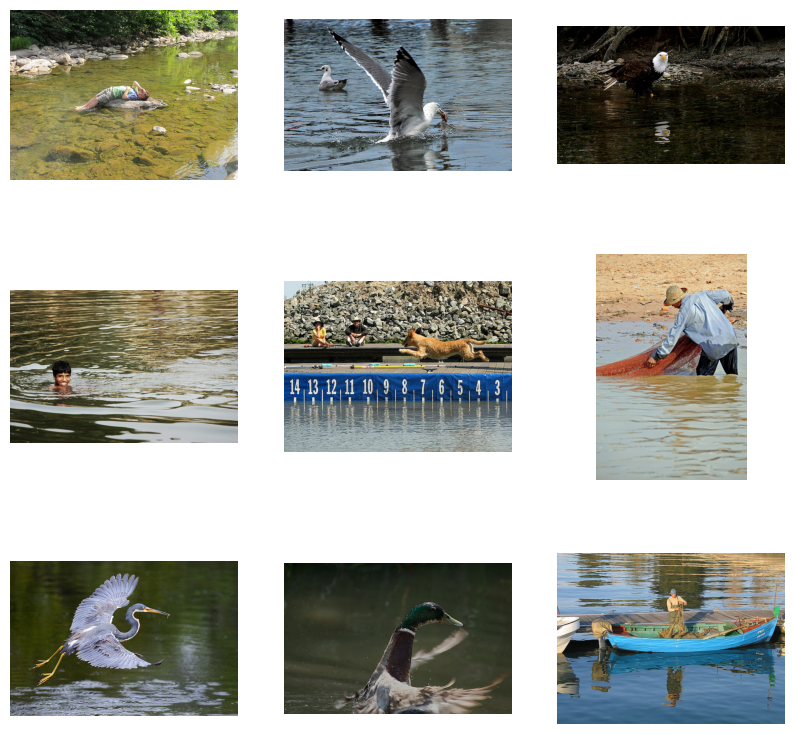

In [ ]:
find_matches_cpu(model_inf,
                 image_embeddings_inf,
                 query="fishes",
                 image_filenames=img_file_names,
                 n=9)

### Saving the validation images in Gray scale via RLE encoding to reduce the size, reading it back from gdrive and trying decoding

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_image_embeddings.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_text_embeddings.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/best_clip_model_cpu.pt" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/val_img_file_names.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/val_imgs_rle_encode.json" '/content/'

#### CFG class & transforms

In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 64
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

In [ ]:
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

#### RLE encode logic and saving to gdrive

In [ ]:
val_img_file_names_np = np.load('/content/val_img_file_names.npy',allow_pickle=True)
print(f'val_img_file_names_np.shape : {val_img_file_names_np.shape}')

val_img_file_names_np.shape : (31780,)


In [ ]:
val_img_file_names_np[:4]

array(['1000919630.jpg', '1000919630.jpg', '1000919630.jpg',
       '1000919630.jpg'], dtype=object)

/content/flickr30k_images/flickr30k_images/1003163366.jpg
(500, 410)


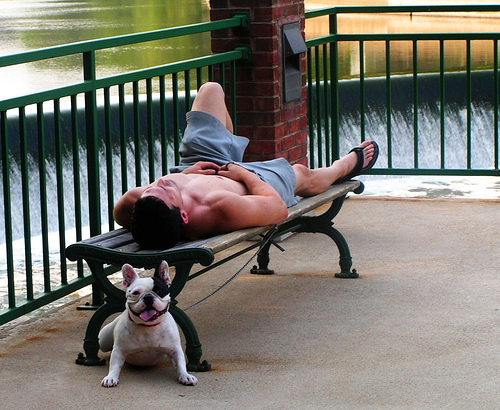

In [ ]:
img_name = '/content/flickr30k_images/flickr30k_images/' + str(val_img_file_names_np[10])
print(img_name)
image = Image.open(img_name)
print(image.size)
image

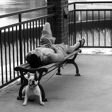

In [ ]:
image = Image.open(img_name).convert('L')
image = image.resize((112, 112))
image

In [ ]:
def rle_encode(img_name, img_size):
    # Load the grayscale image (replace 'your_image.png' with the path to your image)
    image = Image.open(img_name).convert('L')
    image = image.resize(img_size)

    # Convert the grayscale image to a NumPy array
    image_array = np.array(image)

    # Flatten the image array
    flat_image = image_array.flatten()

    # Initialize variables
    encoded_image = []
    count = 1

    # Loop through the flattened image to perform RLE encoding
    for i in range(1, len(flat_image)):
        if flat_image[i] == flat_image[i - 1]:
            count += 1
        else:
            encoded_image.extend([flat_image[i - 1], count])
            count = 1

    # Add the last run
    encoded_image.extend([flat_image[-1], count])
    return encoded_image

# Step 2: Decode RLE Encoded Array to Grayscale Image
def rle_decode(img_rle_array, img_size):
    encoded_image = img_rle_array
    # Initialize variables for decoding
    decoded_image = []
    for i in range(0, len(encoded_image), 2):
        pixel_value = encoded_image[i]
        run_length = encoded_image[i + 1]
        decoded_image.extend([pixel_value] * run_length)
    print(len(decoded_image))

    # Convert the decoded image back to a NumPy array
    decoded_array = np.array(decoded_image, dtype=np.uint8)
    print(decoded_array.shape)

    # Reshape the decoded array to the original image shape (224, 224)
    decoded_image = decoded_array.reshape(img_size)  # Use original shape
    print(decoded_image.shape)

    # Create a PIL Image from the decoded array
    decoded_image = Image.fromarray(decoded_image)

    # Save or display the decoded image
    decoded_image.save('decoded_image.jpg')  # Save the decoded image to a file
    return decoded_image_save_path

In [ ]:
img_shape = (image.size[-1], image.size[0])

In [ ]:
img_rle_array = rle_encode(img_name)
rle_decode(img_rle_array, img_shape)

205000
(205000,)
(410, 500)


In [ ]:
len(val_img_file_names_np)

31780

In [ ]:
val_file_names_set = set()
for idx, img_name in enumerate(val_img_file_names_np):
    val_file_names_set.add(img_name)
print(f'Unique file names in set : {len(val_file_names_set)}')

Unique file names in set : 6356


In [ ]:
val_file_dict = {}
img_size = (112, 112)
for idx, img_name in enumerate(val_file_names_set):
    if idx % 100 == 0:
        print(idx)
    img_path = '/content/flickr30k_images/flickr30k_images/' + img_name
    img_encode_list = rle_encode(img_path, img_size)
    val_file_dict[img_name] = img_encode_list

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300


In [ ]:
type(val_file_dict['2644326817.jpg'][0])

numpy.uint8

In [ ]:
for key, value_list in val_file_dict.items():
    int_list = [int(x) for x in value_list]
    val_file_dict[key] = int_list

In [ ]:
type(val_file_dict['2644326817.jpg'][0])

int

In [ ]:
import json
# Save the JSON string to a JSON file
with open("val_imgs_rle_encode.json", "w") as json_file:
    json.dump(val_file_dict, json_file)

In [ ]:
!cp '/content/val_imgs_rle_encode.json' "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/"

In [ ]:
i = 0
for key, value_list in val_file_dict.items():
    i += 1
print(i)

6356


#### RLE-decode logic & decoding the image back

In [ ]:
# Load the JSON file back into a Python dictionary
with open("/content/val_imgs_rle_encode.json", "r") as json_file:
    val_file_dict_loaded = json.load(json_file)

In [ ]:
i = 0
for key, value_list in val_file_dict_loaded.items():
    i += 1
    if i % 800 == 0:
        print(i, key)
print(i)

800 4451335021.jpg
1600 1835319755.jpg
2400 2955022652.jpg
3200 4520180621.jpg
4000 3458559770.jpg
4800 129321675.jpg
5600 111069375.jpg
6356


In [ ]:
# Step 2: Decode RLE Encoded Array to Grayscale Image
def rle_decode(img_rle_array, img_name, img_size):
    encoded_image = img_rle_array
    # Initialize variables for decoding
    decoded_image = []
    for i in range(0, len(encoded_image), 2):
        pixel_value = encoded_image[i]
        run_length = encoded_image[i + 1]
        decoded_image.extend([pixel_value] * run_length)
    print(len(decoded_image))

    # Convert the decoded image back to a NumPy array
    decoded_array = np.array(decoded_image, dtype=np.uint8)
    print(decoded_array.shape)

    # Reshape the decoded array to the original image shape (224, 224)
    decoded_image = decoded_array.reshape(img_size)  # Use original shape
    print(decoded_image.shape)

    # Create a PIL Image from the decoded array
    decoded_image = Image.fromarray(decoded_image)

    decoded_image_save_path = '/content/' + str(img_name)
    # Save or display the decoded image
    decoded_image.save(decoded_image_save_path)  # Save the decoded image to a file
    return decoded_image_save_path

In [ ]:
img_size = (112, 112)
img_name = "4451335021.jpg"
img_rle_array = val_file_dict_loaded["4451335021.jpg"]
decoded_image_path = rle_decode(img_rle_array, img_name, img_size)
print(decoded_image_path)

12544
(12544,)
(112, 112)
/content/4451335021.jpg


In [ ]:
image = Image.open(decoded_image_path)
new_size = (224, 224)
resized_image = image.resize(new_size)
resized_image_save_path = '/content/' + 'resized_' + str(img_name)
resized_image.save(resized_image_save_path)

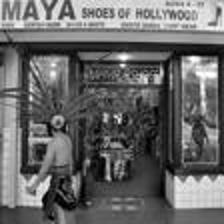

In [ ]:
image = Image.open(resized_image_save_path)
image

In [ ]:
image.size

(224, 224)

### CPU inferencing using model.pt, getting the image similarity, getting the index of image & thereby its name, decode the image from rle json file using image name

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_image_embeddings.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_text_embeddings.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/best_clip_model_cpu.pt" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/val_img_file_names.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/val_imgs_rle_encode.json" '/content/'

In [ ]:
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
def find_matches_cpu(model, image_embeddings, query, image_filenames, n=4):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to('cpu')
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    return matches

In [ ]:
model_inf = CLIPModel().to('cpu')
model_inf.load_state_dict(torch.load('/content/best_clip_model_cpu.pt', map_location='cpu'))

<All keys matched successfully>

In [ ]:
clip_image_embeddings_np_inf = np.load('/content/clip_image_embeddings.npy')
image_embeddings_inf = torch.tensor(clip_image_embeddings_np_inf)

In [ ]:
img_file_names = np.load('/content/val_img_file_names.npy',allow_pickle=True)
print(f'img_file_names.shape : {img_file_names.shape}')

img_file_names.shape : (31780,)


In [ ]:
# Load the JSON file back into a Python dictionary
with open("/content/val_imgs_rle_encode.json", "r") as json_file:
    val_file_dict_loaded = json.load(json_file)

In [ ]:
matches = find_matches_cpu(model_inf,
                 image_embeddings_inf,
                 query="boys playing in a beach",
                 image_filenames=img_file_names,
                 n=9)

In [ ]:
print(matches)

['350630236.jpg', '3649224118.jpg', '2210059361.jpg', '3846534355.jpg', '69152837.jpg', '4982208983.jpg', '2099852435.jpg', '1466752561.jpg', '3741664817.jpg']


In [ ]:
# Step 2: Decode RLE Encoded Array to Grayscale Image
def rle_decode(img_rle_array, img_name, img_size):
    encoded_image = img_rle_array
    # Initialize variables for decoding
    decoded_image = []
    for i in range(0, len(encoded_image), 2):
        pixel_value = encoded_image[i]
        run_length = encoded_image[i + 1]
        decoded_image.extend([pixel_value] * run_length)

    # Convert the decoded image back to a NumPy array
    decoded_array = np.array(decoded_image, dtype=np.uint8)

    # Reshape the decoded array to the original image shape (224, 224)
    decoded_image = decoded_array.reshape(img_size)  # Use original shape

    # Create a PIL Image from the decoded array
    decoded_image = Image.fromarray(decoded_image)

    decoded_image_save_path = '/content/' + str(img_name)
    # Save or display the decoded image
    decoded_image.save(decoded_image_save_path)  # Save the decoded image to a file
    return decoded_image_save_path

In [ ]:
def plot_matches(matches):
    img_size = (112, 112)
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    match_img_list = []
    for img_name in matches:
        img_rle_array = val_file_dict_loaded[img_name]
        decoded_image_path = rle_decode(img_rle_array, img_name, img_size)
        match_img_list.append(decoded_image_path)
    for img_path, ax in zip(match_img_list, axes.flatten()):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

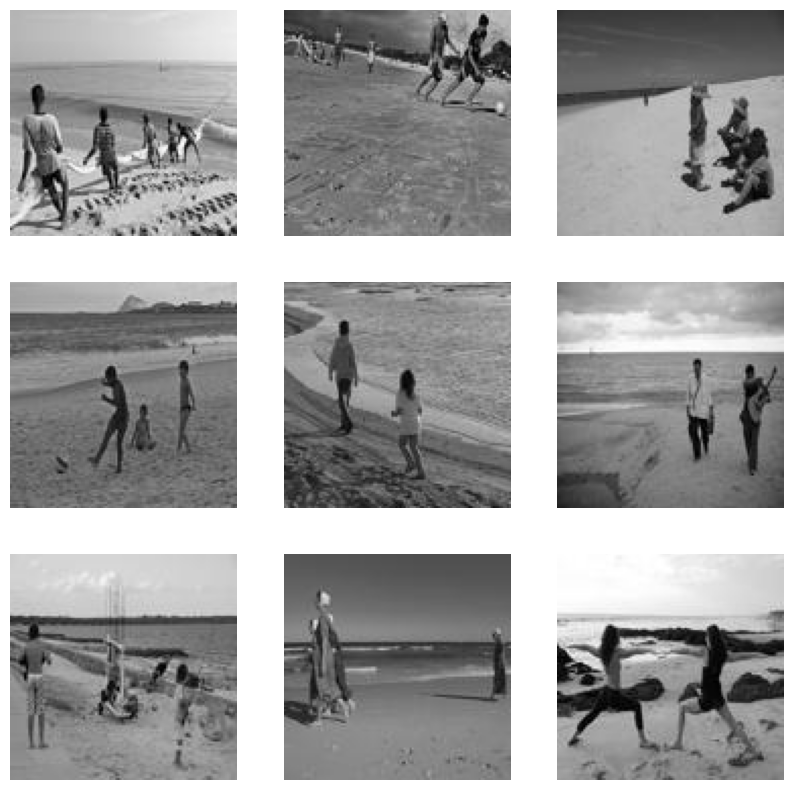

In [ ]:
plot_matches(matches)

### Gradio demo

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_image_embeddings.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/clip_text_embeddings.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/best_clip_model_cpu.pt" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/val_img_file_names.npy" '/content'
!cp "/content/gdrive/MyDrive/ERA1/s19_clip_fastsam/val_imgs_rle_encode.json" '/content/'

In [4]:
import os
import cv2
import numpy as np
from PIL import Image
import json
import gradio as gr
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

#### Defining model classes

In [5]:
class CFG:
    image_path = './images'
    captions_path = './captions'
    batch_size = 64
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        images_similarity = image_embeddings @ text_embeddings.T / self.temperature
        texts_similarity = images_similarity.T
        labels = torch.arange(batch["image"].shape[0]).long().to(CFG.device)

        total_loss = (
            F.cross_entropy(images_similarity, labels) +
            F.cross_entropy(texts_similarity, labels)
        ) / 2

        return total_loss

#### Match Finding logic

In [6]:
def find_matches_cpu(model, image_embeddings, query, image_filenames, n=4):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to('cpu')
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    return matches

In [7]:
def rle_decode(img_rle_array, img_name, img_size):
    encoded_image = img_rle_array
    # Initialize variables for decoding
    decoded_image = []
    for i in range(0, len(encoded_image), 2):
        pixel_value = encoded_image[i]
        run_length = encoded_image[i + 1]
        decoded_image.extend([pixel_value] * run_length)

    # Convert the decoded image back to a NumPy array
    decoded_array = np.array(decoded_image, dtype=np.uint8)

    # Reshape the decoded array to the original image shape (224, 224)
    decoded_image = decoded_array.reshape(img_size)  # Use original shape

    # Create a PIL Image from the decoded array
    decoded_image = Image.fromarray(decoded_image)

    decoded_image_save_path = '/content/' + str(img_name)
    # Save or display the decoded image
    decoded_image.save(decoded_image_save_path)  # Save the decoded image to a file
    return decoded_image_save_path

In [8]:
def get_matched_image(matches, val_file_dict_loaded):
    img_size = (112, 112)
    match_img_list = []
    for img_name in matches:
        img_rle_array = val_file_dict_loaded[img_name]
        decoded_image_path = rle_decode(img_rle_array, img_name, img_size)
        match_img_list.append(decoded_image_path)
    return match_img_list

In [9]:
def get_grayscale_image(text_query):
    model_inf = CLIPModel().to('cpu')
    model_inf.load_state_dict(torch.load('/content/best_clip_model_cpu.pt', map_location='cpu'))

    clip_image_embeddings_np_inf = np.load('/content/clip_image_embeddings.npy')
    image_embeddings_inf = torch.tensor(clip_image_embeddings_np_inf)

    img_file_names = np.load('/content/val_img_file_names.npy',allow_pickle=True)

    with open("/content/val_imgs_rle_encode.json", "r") as json_file:
        val_file_dict_loaded = json.load(json_file)

    matches = find_matches_cpu(model_inf,
                 image_embeddings_inf,
                 query=text_query,
                 image_filenames=img_file_names,
                 n=1)

    matched_images = get_matched_image(matches, val_file_dict_loaded)
    return matched_images

In [10]:
def gradio_fn(text):
    text_query = str(text)
    match_img_list = get_grayscale_image(text_query)
    pil_img = Image.open(match_img_list[0])
    pil_img = pil_img.resize((224, 224))
    np_img_array = np.array(pil_img)
    return np_img_array

In [11]:
demo = gr.Interface(fn=gradio_fn,
                    inputs=gr.Textbox(info="Enter the description of image you wish to search, CLIP will give the best image available in corpus that matches your search"),
                    outputs=gr.Image(height=224, width=224),
                    title="CLIP Image Search")

In [ ]:
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d9eb078b6b949db483.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [16]:
!pip freeze > req.txt